In [3]:
import pandas as pd
import numpy as np
import os
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
import random
import unicodedata
from string import punctuation
from string import digits
from nltk.stem import WordNetLemmatizer
import joblib

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

import spacy
from spacy.matcher import Matcher

from rake_nltk import Rake

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
### Reading data
data_dir = 'data/'
filename_prefix = 'koreaherald_1517_'
df = []

for i in range(8):
    df.append(pd.read_json(os.path.join(data_dir, filename_prefix + str(i) + '.json')))
df = pd.concat(df)
df.reset_index(inplace=True)
df = df.rename(columns=dict(zip(df.columns,[df.columns[i].strip() for i in range(len(df.columns))])))
df.drop('index', inplace=True, axis=1)

df.shape

(23769, 6)

In [5]:
# Load large spacy model 
nlp = spacy.load('en_core_web_lg')

# Aggregate title and content
title_weight = 1
df['agg_title_body'] = title_weight*(df['title']+'. ') + df['body']

In [6]:
### Lemmatization tool
stemmer = WordNetLemmatizer()
### Change similar words to the same word
UN_WORD = "The United Nations"
US_WORD = "The United States"
NK_WORD = "North Korea"
SK_WORD = "South Korea"

similar_words = {
    # Change to "The United States"
    "U.S.": US_WORD,
    "US": US_WORD,
    "USA": US_WORD,
    "United States": US_WORD,
    "United States'": US_WORD,
    "The United States'": US_WORD,
    
    # Change to "North Korea"
    "NK": NK_WORD,
    "NK's": NK_WORD,
    "N. Korea": NK_WORD,
    "N. Korea's": NK_WORD,
    "North Korea's": NK_WORD,
    
    # Change to "South Korea"
    "SK": SK_WORD,
    "SK's": SK_WORD,
    "S. Korea": SK_WORD,
    "S. Korea's": SK_WORD,
    "South Korea's": SK_WORD,
    
    # Change to "The United Nations"
    "United Nations": UN_WORD,
    "United Nations'": UN_WORD,
    "The United Nations'": UN_WORD,
    "UN": UN_WORD,
}

### Transform function
def text_cleaning(s: str):
        
    def replace_strange_char(s: str):
        non_en_chars = {
            "’": "'",
            "‘": "'"
        }

        def remove_non_en_chars(txt):
            # remove non english characters
            txt = convert_latin_chars(txt)
            for char in non_en_chars.keys():
                txt = re.sub(char, non_en_chars[char], txt)
            txt = re.sub(r'[^\x00-\x7F]+', ' ', txt)
            return txt

        def convert_latin_chars(txt):
            # convert latin characters
            return ''.join(char for char in unicodedata.normalize('NFKD', txt) if unicodedata.category(char) != 'Mn')

        s = remove_non_en_chars(s)
        s = convert_latin_chars(s)
        return s
    s = replace_strange_char(s)
    for key,value in similar_words.items():
        s = re.sub(key, value, s)
    return s

# Using spacy to preprocess
def preprocess_spacy(s: str):
    # Change similar terms to the same term
    new_str = text_cleaning(s)
    doc = nlp(s)
    # Group tokens
    matcher = Matcher(nlp.vocab)
    token_groupup_pattern = [
        [{"LOWER": "the"}, {"LOWER": "united"}, {"LOWER": "nations"}],
        [{"LOWER": "the"}, {"LOWER": "united"}, {"LOWER": "states"}],
        [{"LOWER": "north"}, {"LOWER": "korea"}],
        [{"LOWER": "south"}, {"LOWER": "korea"}],
    ]
    matcher.add("TermGroup",token_groupup_pattern)
    matches = matcher(doc)
    merge_doc = []
    for nid, start, end in matches:
        merge_doc.append((start,end))
    with doc.retokenize() as retokenizer:
        for i in range(len(merge_doc)-1,-1,-1):
            retokenizer.merge(doc[merge_doc[i][0]:merge_doc[i][1]])
        
    # Remove all stopword, punctuation, number
    tokens = [ token for token in doc if not token.is_stop and not token.is_punct and not token.like_num]
    new_str = ' '.join([ token.lemma_.lower() for token in tokens ])
    return new_str, tokens, doc

def spacy_tokenizer(s: str):
    # Change similar terms to the same term
    new_str = text_cleaning(s)
    doc = nlp(s)
    # Group tokens
    matcher = Matcher(nlp.vocab)
    token_groupup_pattern = [
        [{"LOWER": "the"}, {"LOWER": "united"}, {"LOWER": "nations"}],
        [{"LOWER": "the"}, {"LOWER": "united"}, {"LOWER": "states"}],
        [{"LOWER": "north"}, {"LOWER": "korea"}],
        [{"LOWER": "south"}, {"LOWER": "korea"}],
    ]
    matcher.add("TermGroup",token_groupup_pattern)
    matches = matcher(doc)
    merge_doc = []
    for nid, start, end in matches:
        merge_doc.append((start,end))
    with doc.retokenize() as retokenizer:
        for i in range(len(merge_doc)-1,-1,-1):
            retokenizer.merge(doc[merge_doc[i][0]:merge_doc[i][1]])
        
    # Remove all stopword, punctuation, number
    tokens = [ token.lemma_.lower() for token in doc \
              if not token.is_stop and not token.is_punct and not token.like_num and token.lemma_.strip()!= '']
    return tokens

### Preprocess function for grouping similar topic
def preprocess_manual(s: str):
    # Change similar words to the same word
    new_str = transform_to_similar_sentence(s)
    # Remove punctuation
    new_str = ''.join(ch if ch not in set(punctuation) else " " for ch in new_str)
    # Remove all single characters
    new_str = re.sub(r'\W', ' ', new_str)
    new_str = re.sub(r'\s+[a-zA-Z]\s+', ' ', new_str)
    new_str = re.sub(r'\^[a-zA-Z]\s+', ' ', new_str) 
    # Substituting multiple spaces with single space
    new_str = re.sub(r'\s+', ' ', new_str, flags=re.I)
    # Removing prefixed 'b' - when data is in bytes format
    new_str = re.sub(r'^b\s+', '', new_str)
    # Removing all numbers
    new_str = new_str.translate(str.maketrans('', '', digits))
    # Converting to Lowercase
    new_str = new_str.lower()
    # Lemmatization and remove stopwords
    new_str = new_str.split()
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [stemmer.lemmatize(word) for word in new_str if word not in stopwords]
    new_str = ' '.join(tokens)
    
    return new_str, tokens

In [7]:
### Make TF-IDF matrix
def tfidf_embed(documents, dimension=None):
    # documents: list of str
    # dim: integer
    embeddings_dict = {}
    tfidf_vectorizer = TfidfVectorizer(input='content', tokenizer=spacy_tokenizer)
    tfidf_vector = tfidf_vectorizer.fit_transform(documents)
    
    # Dimensionality Reduction
    if dimension is not None:
        svd_doc = TruncatedSVD(n_components=dimension, n_iter=5, random_state=42)
        tfidf_vector = svd_doc.fit_transform(tfidf_vector)
    return tfidf_vector

### Make GloVe matrix
glove_file = "../glove.42B.300d.txt"
def glove_word_vector():
    embeddings_dict = {}
    with open(glove_file, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

# Average sum of word vectors
def sentence_embed(sentence, word_vectors, dimension):
    sum_vector = np.zeros(dimension)
    for w in sentence.split():
        if w in word_vectors:
            sum_vector += word_vectors[w]
    return sum_vector/len(sentence)

# Make document vector
def document_embed(documents, embedding_technique='tfidf', dimension=None):
    if embedding_technique=='tfidf':
        doc_vector = tfidf_embed(documents, dimension)
    elif embedding_technique=='glove':
        word_vector = glove_word_vector()
        if dimension is None:
            dimension = 300
        doc_vector = [ sentence_embed(s, word_vector, dimension).tolist() for s in documents ]
    elif embedding_technique=='spacy':
        doc_vector = [doc.vector for doc in documents]
    
    return doc_vector

In [8]:
from datetime import datetime

# Days difference between two datetime
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
    return abs((d2 - d1).days)

# Function returns number of article, number of distinct authors, section of the issue, length
def issue_indicator(news_index):
    num_article = len(news_index)
    num_author = len(df['author'][news_index].unique())
    section = 0
    length = days_between(df['time'][news_index].max(),df['time'][news_index].min())
    return num_article, num_author, section, length

In [26]:
### Clustering 
def document_clustering(doc_vectors, clustering_method='kmeans', evaluate=False):
    if clustering_method=='kmeans':
        # Hyperparameters
        k_event = 10000
        k_issue = 6000
        
        # Clustering event
        kmeans_event = KMeans(n_clusters=k_event, random_state=69).fit(doc_vectors)
        # Represent each event by average sum of related news
        event_vectors = np.zeros((k_event, doc_vectors.shape[1]))
        for i in range(k_event):
            event_vectors[i] = sum(doc_vectors[kmeans_event.labels_ == i])
        
        # Clustering issue
        kmeans_issue = KMeans(n_clusters=k_issue, random_state=69).fit(event_vectors)
        # Represent each issue by average sum of related news
        issue_vectors = np.zeros((k_issue, doc_vectors.shape[1]))
        for i in range(k_issue):
            issue_vectors[i] = sum(event_vectors[kmeans_issue.labels_ == i])

        issue_labels = np.array([ kmeans_issue.labels_[kmeans_event.labels_[i]] for i in range(doc_vectors.shape[0]) ])
        
        return k_issue, k_event, issue_labels, kmeans_event.labels_
    
    elif clustering_method=='DBSCAN':
        
        # Hyperparameters
        doc_eps = 0.195
        doc_neighbors = 1
        event_eps = 0.50
        event_neighbors = 1
        
        '''
            Find best doc_eps and event_eps
        '''
        if evaluate:
            # Find best eps to group same document
            doc_eps_list = [ 0.10 + 0.001*i for i in range(1,301) ]
            doc_score = []
            doc_event = []
            doc_best_score = 0
            doc_best_eps = 0.0001
            for doc_eps in doc_eps_list:
                # Clustering event
                db_event = DBSCAN(metric='cosine', eps=doc_eps, min_samples=doc_neighbors).fit(doc_vectors)
                # Number of clusters in labels, ignoring noise if present.
                n_events_ = len(set(db_event.labels_)) - (1 if -1 in db_event.labels_ else 0)
                if len(set(db_event.labels_)) >= 2 and len(set(db_event.labels_)) <= len(doc_vectors)-1:
                    score_ = silhouette_score(doc_vectors, db_event.labels_)
                else:
                    score_ = -1
                doc_event.append(n_events_)
                doc_score.append(score_)
                if score_ > doc_best_score:
                    doc_best_score = score_
                    doc_best_eps = doc_eps
            print("Best Silhouete score is {} at eps: {} and number of events: {}".format(doc_best_score, doc_eps, n_events_))
            fig = plt.figure()
            plt.plot(doc_eps_list, doc_score)
            fig.suptitle('Doc eps and Silhouette score', fontsize=20)
            plt.xlabel('eps', fontsize=18)
            plt.ylabel('Silhouette score', fontsize=16)
            plt.show()
            
            fig = plt.figure()
            plt.plot(doc_eps_list, doc_event)
            fig.suptitle('Doc eps and number of events', fontsize=20)
            plt.xlabel('eps', fontsize=18)
            plt.ylabel('number of events', fontsize=16)
            plt.show()
            
            # Set doc_eps to the best value
            doc_eps = 0.195
            # Find best eps to group same event
            # Clustering event
            db_event = DBSCAN(metric='cosine',eps=doc_eps, min_samples=doc_neighbors).fit(doc_vectors)
            n_events_ = len(set(db_event.labels_)) - (1 if -1 in db_event.labels_ else 0)
            event_labels = np.array(list(map(lambda x: n_events_ if x==-1 else x, db_event.labels_)))
            event_vectors = np.zeros((n_events_, doc_vectors.shape[1]))
            for i in range(n_events_+1):
                if np.sum(event_labels == i) != 0:
                    event_vectors[i] = np.sum(doc_vectors[event_labels == i], axis=0)/np.sum(event_labels == i)
            
            
#             # Clustering issue
#             event_eps_list = [ 0.2 + 0.001*i for i in range(1,401) ]
#             event_score = []
#             event_issue = []
#             event_best_score = 0
#             event_best_eps = 0.001
#             for event_eps in event_eps_list:
#                 db_issue = DBSCAN(eps=event_eps, min_samples=event_neighbors).fit(event_vectors)
#                 # Number of clusters in labels, ignoring noise if present.
#                 n_issues_ = len(set(db_issue.labels_)) - (1 if -1 in db_issue.labels_ else 0)
#                 if len(set(db_issue.labels_)) >= 2 and len(set(db_issue.labels_)) <= len(event_vectors)-1:
#                     score_ = silhouette_score(event_vectors, db_issue.labels_)
#                 else:
#                     score_ = -1
#                 event_issue.append(n_issues_)
#                 event_score.append(score_)
#                 if score_ > event_best_score:
#                     event_best_score = score_
#                     event_best_eps = event_eps
#             print("Best Silhouete score is {} at eps: {} and number of issues: {}".format(event_best_score, event_eps, n_issues_))
#             fig = plt.figure()
#             plt.plot(event_eps_list, event_score)
#             fig.suptitle('Event eps and Silhouette score', fontsize=20)
#             plt.xlabel('eps', fontsize=18)
#             plt.ylabel('Silhouette score', fontsize=16)
#             plt.show()
            
#             fig = plt.figure()
#             plt.plot(event_eps_list, event_issue)
#             fig.suptitle('Event eps and number of issues', fontsize=20)
#             plt.xlabel('eps', fontsize=18)
#             plt.ylabel('number of issues', fontsize=16)
#             plt.show()
            
            # Set event_eps to best value
            event_eps = 0.4
            # Clustering issue
            db_issue = DBSCAN(metric='cosine', eps=event_eps, min_samples=event_neighbors).fit(event_vectors)
            # Number of clusters in labels, ignoring noise if present.
            n_issues_ = len(set(db_issue.labels_)) - (1 if -1 in db_issue.labels_ else 0)
            n_noise_ = list(db_issue.labels_).count(-1)
            # Represent each issue by average sum of related news
            issue_labels = np.array(list(map(lambda x: n_issues_ if x==-1 else x, db_issue.labels_)))
            issue_vectors = np.zeros((n_issues_, doc_vectors.shape[1]))
            for i in range(n_issues_+1):
                if np.sum(issue_labels == i) != 0:
                    issue_vectors[i] = np.sum(event_vectors[issue_labels == i], axis=0)/np.sum(issue_labels == i)
       
            issue_labels = np.array([ issue_labels[event_labels[i]] for i in range(doc_vectors.shape[0]) ])
        
        else:
            '''
            Clustering using specific value
            '''
            # Clustering event
            db_event = DBSCAN(eps=doc_eps, min_samples=doc_neighbors).fit(doc_vectors)
            # Number of clusters in labels, ignoring noise if present.
            n_events_ = len(set(db_event.labels_)) - (1 if -1 in db_event.labels_ else 0)
            n_noise_ = list(db_event.labels_).count(-1)
            print("1st cluster:\n\tThe number of cluster is {}".format(n_events_))
            # Represent each event by average sum of related news
            event_labels = np.array(list(map(lambda x: n_events_ if x==-1 else x, db_event.labels_)))
            event_vectors = np.zeros((n_events_, doc_vectors.shape[1]))
            for i in range(n_events_+1):
                if np.sum(event_labels == i) != 0:
                    event_vectors[i] = np.sum(doc_vectors[event_labels == i], axis=0)/np.sum(event_labels == i)

            # Clustering issue
            db_issue = DBSCAN(eps=event_eps, min_samples=event_neighbors).fit(event_vectors)
            # Number of clusters in labels, ignoring noise if present.
            n_issues_ = len(set(db_issue.labels_)) - (1 if -1 in db_issue.labels_ else 0)
            n_noise_ = list(db_issue.labels_).count(-1)
            print("2nd cluster:\n\tThe number of cluster is {}".format(n_issues_))
            # Represent each issue by average sum of related news
            issue_labels = np.array(list(map(lambda x: n_issues_ if x==-1 else x, db_issue.labels_)))
            issue_vectors = np.zeros((n_issues_, doc_vectors.shape[1]))
            for i in range(n_issues_+1):
                if np.sum(issue_labels == i) != 0:
                    issue_vectors[i] = np.sum(event_vectors[issue_labels == i], axis=0)/np.sum(issue_labels == i)
        
            issue_labels = np.array([ issue_labels[event_labels[i]] for i in range(doc_vectors.shape[0]) ])
        
        return n_issues_, n_events_, issue_labels, event_labels
    
    elif clustering_method=='agglomerative':
        # Hyperparameters
        n_events = 10000
        n_issues = 6000
        
        # Clustering event
        agg_event = AgglomerativeClustering(distance_threshold=0, n_clusters=n_events).fit(doc_vectors)
        # Represent each event by average sum of related news
        event_vectors = np.zeros((n_events, doc_vectors.shape[1]))
        for i in range(n_events):
            event_vectors[i] = sum(doc_vectors[agg_event.labels_ == i])
        
        plt.title("Hierarchical Clustering Dendrogram")
        # plot the top three levels of the dendrogram
        plot_dendrogram(agg_event, truncate_mode="level", p=3)
        plt.xlabel("Number of points in node (or index of point if no parenthesis).")
        plt.show()
        
        # Clustering issue
        agg_issue = AgglomerativeClustering(distance_threshold=0, n_clusters=n_issues).fit(event_vectors)
        # Represent each issue by average sum of related news
        issue_vectors = np.zeros((n_issues, doc_vectors.shape[1]))
        for i in range(n_issues):
            issue_vectors[i] = sum(event_vectors[agg_issue.labels_ == i])

        issue_labels = np.array([ agg_issue.labels_[agg_event.labels_[i]] for i in range(doc_vectors.shape[0]) ])
        
        return agg_issue, agg_event, issue_labels, agg_event.labels_
    
    elif clustering_method=='LDA':
        
        pass
    
    else:
        assert("Doesn't support {}".format(clustering_method))   

In [27]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [19]:
### Embed document and clustering
df2017 = df['2017' < df['time']]
df2016 = df[('2016' < df['time']) & (df['time'] < '2017')]
df2015 = df[('2015' < df['time']) & (df['time'] < '2016')]

In [ ]:
# tfidf_doc2017_vectors = document_embed(df2017, embedding_technique='tfidf', dimension=300)
# tfidf_doc2016_vectors = document_embed(df2016, embedding_technique='tfidf', dimension=300)
# tfidf_doc2015_vectors = document_embed(df2015, embedding_technique='tfidf', dimension=300)

In [12]:
# Load data
tfidf_doc2017_vectors = joblib.load('tfidf_titlebody_2017.csv')
tfidf_doc2016_vectors = joblib.load('tfidf_titlebody_2016.csv')
tfidf_doc2015_vectors = joblib.load('tfidf_titlebody_2015.csv')

In [13]:
# Visualization
num_clusters = 1000
pca_num_components = 2
tsne_num_components = 2
max_iterations = 100

color_list = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(num_clusters)]
labels_color_map = dict([(i,x) for (i,x) in enumerate(color_list)])

C:\Users\Modern\anaconda3\envs\text-mining\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\Modern\anaconda3\envs\text-mining\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


<Figure size 432x288 with 0 Axes>

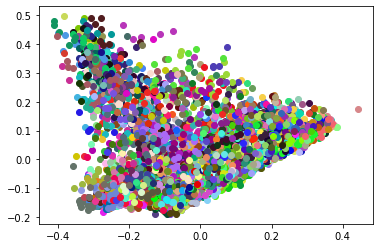

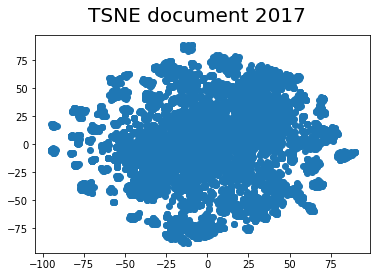

In [14]:
### 2017
### PCA 2D visualization
X = tfidf_doc2017_vectors
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)
labels = clustering_model.fit_predict(X)

fig = plt.figure()
fig.suptitle('PCA document 2017', fontsize=20)
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

### TSNE 2D visualization
fig = plt.figure()
fig.suptitle('TSNE document 2017', fontsize=20)
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

C:\Users\Modern\anaconda3\envs\text-mining\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\Modern\anaconda3\envs\text-mining\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


<Figure size 432x288 with 0 Axes>

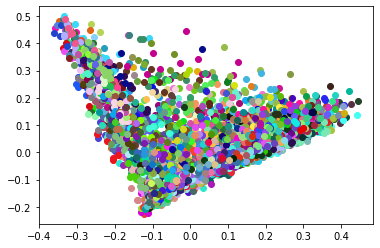

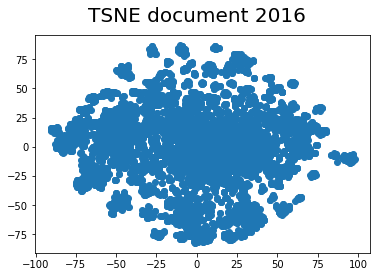

In [15]:
### 2016
### PCA 2D visualization
X = tfidf_doc2016_vectors
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)
labels = clustering_model.fit_predict(X)

fig = plt.figure()
fig.suptitle('PCA document 2016', fontsize=20)
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

### TSNE 2D visualization
fig = plt.figure()
fig.suptitle('TSNE document 2016', fontsize=20)
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

C:\Users\Modern\anaconda3\envs\text-mining\lib\site-packages\sklearn\cluster\_kmeans.py:788: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25). It has no effect
  ". It has no effect", FutureWarning)
C:\Users\Modern\anaconda3\envs\text-mining\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


<Figure size 432x288 with 0 Axes>

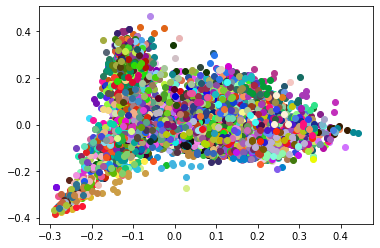

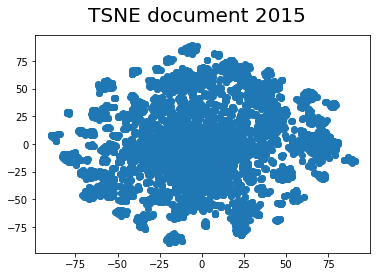

In [16]:
### 2015
### PCA 2D visualization
X = tfidf_doc2015_vectors
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)
labels = clustering_model.fit_predict(X)

fig = plt.figure()
fig.suptitle('PCA document 2015', fontsize=20)
reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.show()

### TSNE 2D visualization
fig = plt.figure()
fig.suptitle('TSNE document 2015', fontsize=20)
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.show()

Best Silhouete score is 0.03983963190347608 at eps: 0.4 and number of events: 616


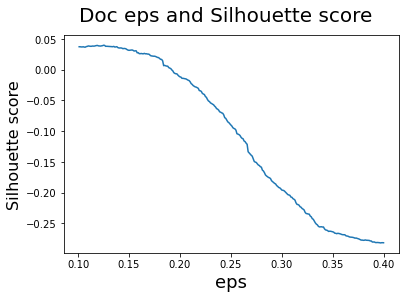

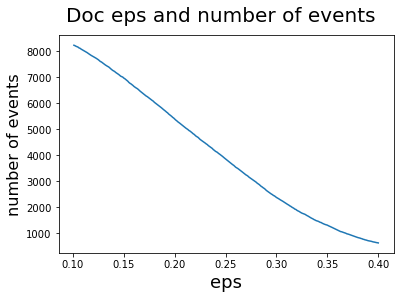

In [28]:
tfidf_doc2017_num_issue, tfidf_doc2017_num_event, tfidf_doc2017_issue_labels, tfidf_doc2017_event_labels = document_clustering(tfidf_doc2017_vectors, clustering_method='DBSCAN', evaluate=True)

In [ ]:
tfidf_doc2016_num_issue, tfidf_doc2016_num_event, tfidf_doc2016_issue_labels, tfidf_doc2016_event_labels = document_clustering(tfidf_doc2016_vectors, clustering_method='DBSCAN', evaluate=True)

In [ ]:
tfidf_doc2015_num_issue, tfidf_doc2015_num_event, tfidf_doc2015_issue_labels, tfidf_event_labels = document_clustering(tfidf_doc2015_vectors, clustering_method='DBSCAN', evaluate=True)

In [ ]:
tfidf_doc2015_num_issue, tfidf_doc2015_num_event, tfidf_doc2015_issue_labels, tfidf_doc2015_event_labels = document_clustering(tfidf_doc2015_vectors, clustering_method='DBSCAN', evaluate=False)

In [ ]:
tfidf_doc2016_num_issue, tfidf_doc2016_num_event, tfidf_doc2016_issue_labels, tfidf_doc2016_event_labels = document_clustering(tfidf_doc2016_vectors, clustering_method='DBSCAN', evaluate=False)

In [ ]:
tfidf_doc2017_num_issue, tfidf_doc2017_num_event, tfidf_doc2017_issue_labels, tfidf_doc2017_event_labels = document_clustering(tfidf_doc2017_vectors, clustering_method='DBSCAN', evaluate=False)

In [ ]:
print("Number of document in 2017: {} / {} clusters".format(len(tfidf_doc2017_vectors), tfidf_doc2017_num_event))
print("Number of document in 2016: {} / {} clusters".format(len(tfidf_doc2016_vectors), tfidf_doc2016_num_event))
print("Number of document in 2015: {} / {} clusters".format(len(tfidf_doc2015_vectors), tfidf_doc2015_num_event))

In [ ]:
from collections import Counter
counter_2017_event = Counter(tfidf_doc2017_event_labels)
counter_2016_event = Counter(tfidf_doc2016_event_labels)
counter_2015_event = Counter(tfidf_doc2015_event_labels)

In [ ]:
top10_event_2017 = counter_2017_event.most_common(10)

In [ ]:
top10_event_2016 = counter_2016_event.most_common(10)

In [ ]:
top10_event_2015 = counter_2015_event.most_common(10)

In [ ]:
# Function returns number of article, number of distinct authors, section of the issue, length
def issue_indicator(news_index):
    num_article = len(news_index)
    num_author = len(df['author'][news_index].unique())
    section = 0
    length = days_between(df['time'][news_index].max(),df['time'][news_index].min())
    return num_article, num_author, section, length

### Rank issues based on significance factors
issue_doc2017_significance = []
for issue_index in range(tfidf_doc2017_num_issue):
    news_index = np.argwhere(tfidf_doc2017_issue_labels == issue_index).reshape(-1)
    if len(news_index) > 0:
        issue_doc2017_significance.append((issue_indicator(news_index),issue_index))
issue_doc2017_significance = sorted(issue_doc2017_significance, key=lambda k: (-k[0][0],-k[0][1],-k[0][3]))
top_doc2017_10_issue = [ info[1] for info in issue_doc2017_significance[:10]]

### Rank issues based on significance factors
issue_doc2016_significance = []
for issue_index in range(tfidf_doc2016_num_issue):
    news_index = np.argwhere(tfidf_doc2016_issue_labels == issue_index).reshape(-1)
    if len(news_index) > 0:
        issue_doc2016_significance.append((issue_indicator(news_index),issue_index))
issue_doc2016_significance = sorted(issue_doc2016_significance, key=lambda k: (-k[0][0],-k[0][1],-k[0][3]))
top_doc2016_10_issue = [ info[1] for info in issue_doc2016_significance[:10]]

### Rank issues based on significance factors
issue_doc2015_significance = []
for issue_index in range(tfidf_doc2015_num_issue):
    news_index = np.argwhere(tfidf_doc2015_issue_labels == issue_index).reshape(-1)
    if len(news_index) > 0:
        issue_doc2015_significance.append((issue_indicator(news_index),issue_index))
issue_doc2015_significance = sorted(issue_doc2015_significance, key=lambda k: (-k[0][0],-k[0][1],-k[0][3]))
top_doc2015_10_issue = [ info[1] for info in issue_doc2015_significance[:10]]

In [ ]:
top_doc2017_10_issue

In [ ]:
top_doc2016_10_issue

In [ ]:
top_doc2015_10_issue